## 完成一个神经网络框架

## 构建基类

In [1]:
import numpy as np

In [89]:
class Node():
    
    def __init__(self,inputs=[]):
        self.inputs = inputs
        self.value = None
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:
            node.outputs.append(self)
    
    def forward(self):
        
        return NotImplemented
    
    def backward(self):
        
        return NotImplemented

In [90]:
class Input(Node):
    
    def __init__(self,name=''):
        Node.__init__(self,inputs=[])
        self.name = name
        
    def forward(self,value=None):
        if value is not None:
            self.value = value
    
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node:{}'.format(self.name)

In [119]:
class Linear(Node):
    
    def __init__(self,nodes,weights,bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self,inputs=[nodes,weights,bias])
        
    def forward(self):
        self.value = np.dot(self.x_node.value,self.w_node.value) + self.b_node.value
    
    def backward(self):
        for node in self.outputs:
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T,grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1,axis=0,keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost,self.w_node.value.T)


In [92]:
class Sigmoid(Node):
    def __init__(self,node):
        Node.__init__(self,[node])
        self.x_node = node
        
    def _sigmoid(self,x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
        
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial
        

In [93]:
class MSE(Node):
    def __init__(self,y_true,y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self,inputs=[y_true,y_hat])
        
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)
        self.diff = y_true_flatten - y_hat_flatten
        self.value = np.mean(self.diff**2)
    
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff
    

In [94]:
def training_one_batch(topological_sorted_graph):
    
    for node in topological_sorted_graph:
        node.forward()
    for node in topological_sorted_graph[::-1]:
        node.backward()
    

In [95]:
def topological_sort(data_with_value):
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in':set(),'out':set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in':set(),'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n,Input):
            n.value = feed_dict[n]
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    
    return L


In [96]:
def sgd_update(trainable_nodes,learning_rate= 1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

# 导入数据

In [97]:
from sklearn.datasets import load_boston

In [98]:
data = load_boston()

In [99]:
X_ = data['data']

In [100]:
y_ = data['target']

In [101]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [102]:
y_[0]

24.0

In [103]:
X_.shape

(506, 13)

In [104]:
X_ = (X_ - np.mean(X_,axis=0)) / np.std(X_,axis=0)

In [105]:
n_features = X_.shape[1]

In [106]:
n_hidden = 10

In [107]:
W1_,b1_ = np.random.randn(n_features,n_hidden),np.zeros(n_hidden)

In [108]:
W2_,b2_ = np.random.randn(n_hidden,1),np.zeros(1)

+ 在图中建立Node

In [120]:
X,y = Input(name='X'),Input(name='y')
W1,b1 = Input(name='W1'),Input(name='b1')
W2,b2 = Input(name='W2'),Input(name='b2')

+ 建立连接关系

In [121]:
linear_output = Linear(X,W1,b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output,W2,b2)
loss = MSE(y,yhat)

In [122]:
input_node_with_value = {
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_
}

In [123]:
graph = topological_sort(input_node_with_value)

In [124]:
graph

[Input Node:X,
 Input Node:W1,
 Input Node:W2,
 Input Node:b1,
 Input Node:y,
 Input Node:b2,

In [125]:
from sklearn.utils import resample

In [126]:
def run(dictionary):
    return topological_sort(dictionary)

In [128]:
losses = []
epochs = 5000
batch_size = 64
steps_per_epoch = X_.shape[0] // batch_size

for i in range(epochs):
    loss = 0
    for batch in range(step_per_epoch):
        
        X_batch,y_batch = resample(X_,y_,n_samples=batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
        training_one_batch(graph)
        learning_rate = 1e-3
        sgd_update(trainable_nodes=[W1,W2,b1,b2],learning_rate=learning_rate)
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 530.467
Epoch: 101, loss = 29.643
Epoch: 201, loss = 19.074
Epoch: 301, loss = 21.153
Epoch: 401, loss = 22.685
Epoch: 501, loss = 14.786
Epoch: 601, loss = 11.634
Epoch: 701, loss = 13.141
Epoch: 801, loss = 14.131
Epoch: 901, loss = 13.063
Epoch: 1001, loss = 13.168
Epoch: 1101, loss = 12.123
Epoch: 1201, loss = 12.604
Epoch: 1301, loss = 11.772
Epoch: 1401, loss = 9.756
Epoch: 1501, loss = 11.725
Epoch: 1601, loss = 9.574
Epoch: 1701, loss = 10.392
Epoch: 1801, loss = 11.622
Epoch: 1901, loss = 8.768
Epoch: 2001, loss = 8.347
Epoch: 2101, loss = 8.028
Epoch: 2201, loss = 10.937
Epoch: 2301, loss = 8.739
Epoch: 2401, loss = 9.335
Epoch: 2501, loss = 7.678
Epoch: 2601, loss = 7.822
Epoch: 2701, loss = 7.260
Epoch: 2801, loss = 7.735
Epoch: 2901, loss = 8.178
Epoch: 3001, loss = 10.073
Epoch: 3101, loss = 7.584
Epoch: 3201, loss = 7.456
Epoch: 3301, loss = 7.886
Epoch: 3401, loss = 7.585
Epoch: 3501, loss = 8.188
Epoch: 3601, loss = 7.012
Epoch: 3701, loss = 7.758
Epoc

In [129]:
import matplotlib.pyplot as plt

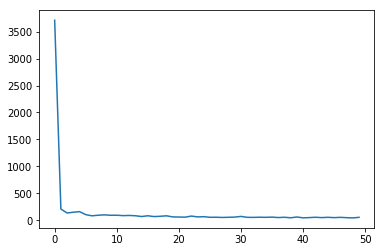

In [130]:
plt.plot(losses)

In [131]:
W1.value

array([[ 3.11386175, -0.90226281,  0.01271458, -1.4335739 , -0.67205448,
        -0.77028151, -0.25864355, -0.55791216, -2.20477011, -1.61521442],
       [ 0.74674825,  1.18576507, -0.69428817,  1.6835641 , -3.03406855,
         0.82101669, -0.34881776, -0.79269591,  1.31143381, -0.43217941],
       [ 0.73836241,  0.71332156, -0.20848788,  0.87970193, -1.38420119,
        -1.37907963, -0.45181744,  0.02200163,  0.75504297, -2.02428975],
       [-0.23785689,  0.37582161, -0.27067945, -0.17992778,  0.4714536 ,
         0.25694686,  0.61196071,  0.0387674 ,  0.01855415, -2.36211977],
       [ 0.56608791, -0.30606106,  3.89181425, -2.83204936, -2.44989404,
        -1.7829909 , -0.62734093,  0.06541971,  0.86703453, -0.45269886],
       [ 2.06794214, -1.17297087,  1.47203411,  0.76363131, -1.30413222,
        -0.80603988,  1.1107409 ,  2.03370633,  1.31687335, -0.61869313],
       [-0.58793398, -0.29904464, -1.52836212, -0.21450177,  1.51922023,
         0.93148638,  1.25091132, -1.00699261

In [132]:
W2.value

array([[6.09581654],
       [4.99348429],
       [4.99594036],
       [6.61215772],
       [4.21201163],
       [7.18462012],
       [6.07457975],
       [9.21298714],
       [6.62892565],
       [1.84620029]])

In [134]:
x1 = Input()
x1.value = X_[1]
def _sigmoid(x):
    return 1. / (1 + np.exp(-1 * x))
np.dot(_sigmoid(np.dot(X_[1], W1.value) + b1.value), W2.value) + b2.value

array([24.19265007])

In [135]:
y_[1]

21.6